In [1]:
%load_ext autoreload
%autoreload 2

# TauREx 3.1

![alt text](taurex31.jpeg "Title")

## I have no clue what this demo is

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from taurex.log import disableLogging, enableLogging
from ipywidgets import *
import numpy as np

disableLogging()


## What is TauREx?

#### TauREx is a framework that allows lots of exoplanet modules and components to talk together and perform retrievals
#### The whole idea is to write once and use lots of times. Everything should work together and you are to use all or part of it to simulate and/or retrieve exoplanet spectra.

In [2]:
from taurex.cache import OpacityCache, CIACache, GlobalCache
OpacityCache().clear_cache()
OpacityCache().set_opacity_path('/Users/ahmed/Documents/taurex_files/xsec/TauRex_sampled_xsecs_R10000_0.3-15/')
CIACache().set_cia_path('/Users/ahmed/Documents/taurex_files/taurex_cobweb/Input/cia/hitran/')

### Lets include ktables as well 🤢

In [3]:
from taurex.cache.ktablecache import KTableCache
KTableCache().clear_cache()
KTableCache().set_ktable_path('/Users/ahmed/Documents/repos/petitRADTRANS/petitRADTRANS/input_data/opacities/lines/corr_k')

# 🤮

exorad.arielRad - INFO - code version 2.4.6
exorad.arielRad - INFO - based on ExoRad 2.1.94


interactive(children=(IntSlider(value=2000, description='T', max=4000, min=400), FloatSlider(value=100.0, desc…

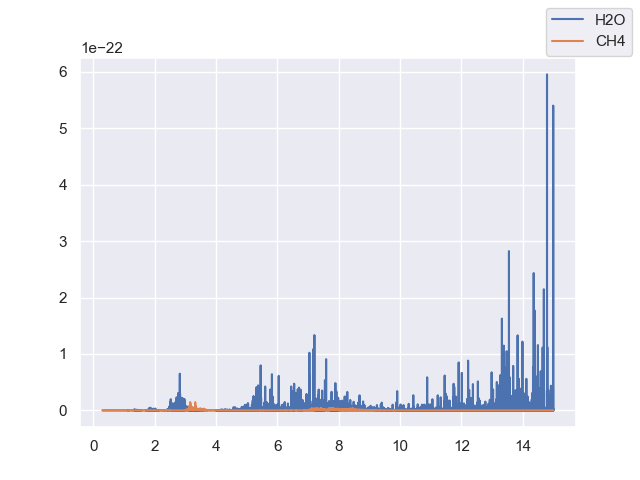

In [4]:
h2o = OpacityCache()['H2O']
ch4 = OpacityCache()['CH4']
xsec_fig = plt.figure()
xsec_ax = xsec_fig.add_subplot(1, 1, 1)



xsec_res, = xsec_ax.plot(10000/h2o.wavenumberGrid,h2o.opacity(1000,1e3), label='H2O')
xsec_res2, = xsec_ax.plot(10000/ch4.wavenumberGrid,ch4.opacity(1000,1e3), label='CH4')
xsec_fig.legend()
def xsec_update(T = 2000.0, P=1e2):
    
    xsec_res.set_ydata(h2o.opacity(T,P))
    xsec_res2.set_ydata(ch4.opacity(T,P))
    xsec_fig.canvas.draw_idle()
    xsec_ax.relim()
    xsec_ax.autoscale_view()

interact(xsec_update, T=(400,4000), P=(1e-4,1e7));

In [5]:
from taurex.cache import OpacityCache, CIACache, GlobalCache
OpacityCache().clear_cache()
OpacityCache().set_opacity_path('/Users/ahmed/Documents/repos/Exo_Transmit/Opac/')
CIACache().set_cia_path('/Users/ahmed/Documents/taurex_files/taurex_cobweb/Input/cia/hitran/')

interactive(children=(IntSlider(value=2000, description='T', max=4000, min=400), FloatSlider(value=1.0, descri…

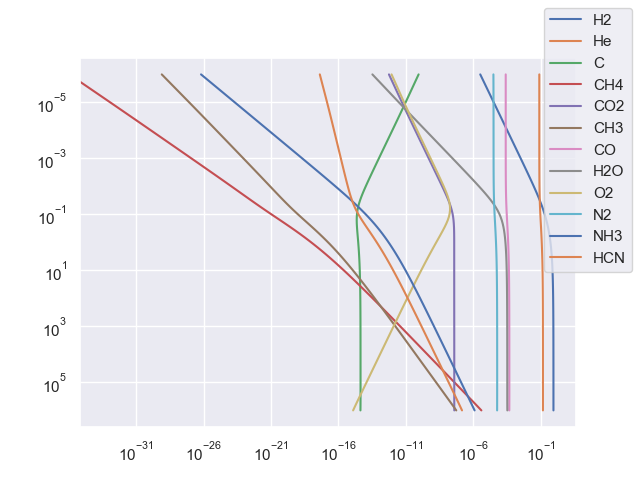

In [7]:
from taurex_ace import ACEChemistry
from taurex_fastchem import FastChem



chosen_molecule = [
    'H2',
    'He',
    'C',
    'CH4',
    'CO2',
    'CH3',
    'CO',
    'H2O',
    'O2',
    'N2',
    'NH3',
    'HCN',
]

nlayers = 100
P = np.logspace(6,-6,nlayers)
T = np.ones_like(P)*1000
ace = FastChem()

ace_fig = plt.figure()
ace_ax = ace_fig.add_subplot(1, 1, 1)

ace.initialize_chemistry(nlayers,pressure_profile=P, temperature_profile=T)


ace_res = [ ace_ax.plot(ace.mixProfile[ace.gases.index(x)],P, label=x) for x in chosen_molecule]
ace_ax.set_yscale('log')
ace_ax.set_xscale('log')
ace_ax.invert_yaxis()
ace_fig.legend()
def update(T = 2000.0, Z=1.0, CO=0.5):
    ace.aceMetallicity = Z
    ace.aceCORatio = CO
    ace.initialize_chemistry(nlayers,pressure_profile=P, temperature_profile=np.ones_like(P)*T)
    
    for mol,r in zip(chosen_molecule, ace_res):
        r[0].set_xdata(ace.mixProfile[ace.gases.index(mol)])
    ace_fig.canvas.draw_idle()

interact(update, T=(400,4000), Z =(0.1,5.0), CO=(0.1,4.0));

interactive(children=(IntSlider(value=2000, description='T', max=8000, min=400, step=400), IntSlider(value=100…

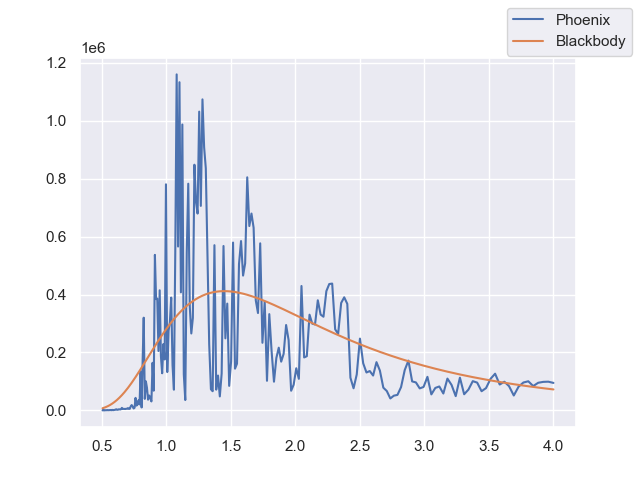

In [8]:
from taurex.stellar import BlackbodyStar, PhoenixStar
from taurex.util.util import create_grid_res

ps = PhoenixStar(phoenix_path='/Users/ahmed/Downloads/BT-Settl_M-0.0a+0.0/')
bs = BlackbodyStar()

wngrid = 10000/create_grid_res(100,0.5,4.0)[:,0]

ps_fig = plt.figure()
ps_ax = ps_fig.add_subplot(1, 1, 1)

ps.initialize(wngrid)
bs.initialize(wngrid)

star_res, = ps_ax.plot(10000/wngrid,ps.spectralEmissionDensity, label='Phoenix')
star_resbb, = ps_ax.plot(10000/wngrid,bs.spectralEmissionDensity, label='Blackbody')
ps_fig.legend()
def star_update(T = 2000.0, resol=100):
    wngrid = 10000/create_grid_res(resol,0.5,4.0)[:,0]
    ps.temperature = T
    bs.temperature = T
    ps.initialize(wngrid)
    bs.initialize(wngrid)
    
    star_res.set_data(10000/wngrid,ps.spectralEmissionDensity)
    star_resbb.set_data(10000/wngrid,bs.spectralEmissionDensity)
    ps_fig.canvas.draw_idle()
    ps_ax.relim()
    ps_ax.autoscale_view()

interact(star_update, T=(400,8000,400), resol=(10,2000,100));

In [9]:
from taurex.model import TransmissionModel
from taurex_ace import ACEChemistry
from taurex.planet import Planet
from taurex.contributions import AbsorptionContribution, CIAContribution, RayleighContribution
from taurex_fastchem import FastChem
from taurex.temperature import Isothermal, Guillot2010

iso_temp = Guillot2010()

star =PhoenixStar(phoenix_path='/Users/ahmed/Downloads/BT-Settl_M-0.0a+0.0/')
planet = Planet()
chemistry = ACEChemistry()

ace_tm = TransmissionModel(temperature_profile=iso_temp, star=star, planet=planet,
                       chemistry=chemistry)
ace_tm.add_contribution(AbsorptionContribution())
ace_tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
ace_tm.add_contribution(RayleighContribution())
ace_tm.build()
ace_tm.model()

(array([  333.33015336,   333.66299682,   333.996171  , ...,
        33292.47436734, 33325.7180735 , 33358.99507388]),
 array([0.01160801, 0.01117214, 0.01128102, ..., 0.011048  , 0.0110483 ,
        0.0110486 ]),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.33378100e-007, 2.33378620e-007, 2.31876186e-007],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.71306343e-151, 3.91970613e-152, 8.85872731e-153],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         6.12412979e-120, 1.89524238e-120, 5.80525406e-121],
        ...,
        [9.99697703e-001, 9.99999589e-001, 9.99997653e-001, ...,
         9.99999933e-001, 9.99999932e-001, 9.99999932e-001],
        [9.99800467e-001, 9.99999729e-001, 9.99998451e-001, ...,
         9.99999956e-001, 9.99999956e-001, 9.99999955e-001],
        [9.99899910e-001, 9.99999864e-001, 9.99999223e-001, ...,
         9.99999978e-001, 9.99999978e-001, 9.99999978e-001]]),
 None)

In [10]:
from taurex.model import EmissionModel
from taurex_ace import ACEChemistry
from taurex.contributions import AbsorptionContribution, CIAContribution, RayleighContribution
from taurex_fastchem import FastChem
from taurex.temperature import Isothermal

ace_em = EmissionModel(temperature_profile=iso_temp, star=star, planet=planet,
                       chemistry=chemistry)
ace_em.add_contribution(AbsorptionContribution())
ace_em.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
ace_em.add_contribution(RayleighContribution())
ace_em.build()
ace_em.model()


(array([  333.33015336,   333.66299682,   333.996171  , ...,
        33292.47436734, 33325.7180735 , 33358.99507388]),
 array([3.27181505e-03, 3.67891174e-03, 3.48190565e-03, ...,
        3.35639935e-10, 2.23280083e-10, 2.12440983e-10]),
 array([[0.00000000e+000, 4.80011328e-138, 2.48553240e-243, ...,
         1.28380630e-004, 1.23736690e-004, 1.19218356e-004],
        [0.00000000e+000, 1.13383400e-107, 1.98571434e-190, ...,
         7.54981052e-004, 7.33634923e-004, 7.12680961e-004],
        [0.00000000e+000, 2.12760347e-084, 1.07518068e-149, ...,
         2.94400402e-003, 2.87965143e-003, 2.81601013e-003],
        ...,
        [2.15119525e-006, 2.92402369e-009, 1.67004744e-008, ...,
         4.80558149e-010, 4.82657581e-010, 4.86359397e-010],
        [1.71056935e-006, 2.32509623e-009, 1.32797174e-008, ...,
         3.79457354e-010, 3.81114917e-010, 3.84210663e-010],
        [1.36011926e-006, 1.84874316e-009, 1.05590411e-008, ...,
         2.99344660e-010, 3.00652392e-010, 3.03251646e

In [11]:
from taurex.binning import FluxBinner
bin_grid = 10000/create_grid_res(100,0.5,4.0)[::-1,0]
fb = FluxBinner(wngrid=bin_grid)


interactive(children=(FloatSlider(value=1.0, description='R', max=4.0, min=0.5), IntSlider(value=2000, descrip…

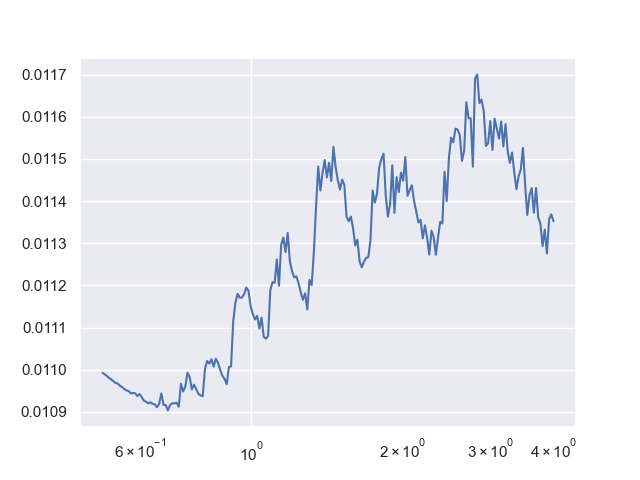

In [12]:

tm_fig = plt.figure()
tm_ax = tm_fig.add_subplot(1, 1, 1)



res, = tm_ax.plot(10000/bin_grid,fb.bin_model(ace_tm.model(bin_grid))[1])
tm_ax.set_xscale('log')
#tm_fig.legend()
def tm_update(R=1.0, T = 2000.0, Z=1.0, CO=0.5, ktables=False):
    if ktables:
        GlobalCache()['opacity_method'] = 'ktables'
#         chemistry = ACEChemistry()
#         ace_tm = TransmissionModel(temperature_profile=iso_temp, star=star, planet=planet,
#                                chemistry=chemistry)
#         ace_tm.build()
    else:
        GlobalCache()['opacity_method'] = 'xsec'
#         chemistry = ACEChemistry()

#         ace_tm = TransmissionModel(temperature_profile=iso_temp, star=star, planet=planet,
#                                chemistry=chemistry)
#         ace_tm.build()
    ace_tm['planet_radius'] = R
    ace_tm['T_irr'] = T
    ace_tm['metallicity'] = Z
    ace_tm['C_O_ratio'] = CO
    res.set_ydata(fb.bin_model(ace_tm.model(bin_grid))[1])
    
    tm_fig.canvas.draw_idle()
    tm_ax.relim()
    tm_ax.autoscale_view()
    

interact(tm_update,R=(0.5,4.0), T=(400,4000,400), Z =(0.1,5.0,0.5), CO=(0.1,4.0));

In [13]:
GlobalCache()['opacity_method'] = 'xsec'

interactive(children=(FloatSlider(value=1.0, description='R', max=4.0, min=0.5, step=0.5), IntSlider(value=200…

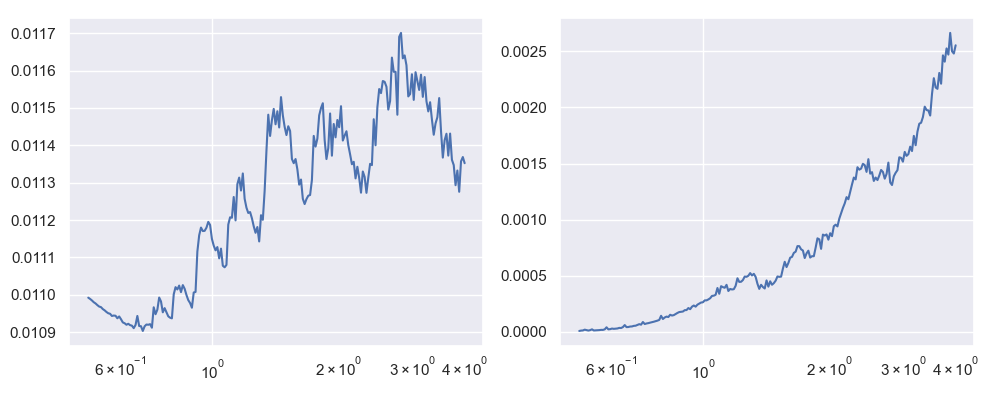

In [14]:
em_fig = plt.figure(figsize=(10,4))
em_ax_1 = em_fig.add_subplot(1, 2, 1)
em_ax_2 = em_fig.add_subplot(1, 2, 2)


res, = em_ax_1.plot(10000/bin_grid,fb.bin_model(ace_tm.model(bin_grid))[1])
res2, = em_ax_2.plot(10000/bin_grid,fb.bin_model(ace_em.model(bin_grid))[1])
em_ax_1.set_xscale('log')
em_ax_2.set_xscale('log')
#tm_fig.legend()
def em_update(R=1.0, T = 2000.0, Z=1.0, CO=0.5,T_star=5700):
    if False:
        GlobalCache()['opacity_method'] = 'ktables'
    else:
        GlobalCache()['opacity_method'] = 'xsec'
    print(R)
    ace_tm['planet_radius'] = R
    ace_tm['T_irr'] = T
    ace_tm['metallicity'] = Z
    ace_tm['C_O_ratio'] = CO
    ace_tm.star.temperature = T_star
    res.set_ydata(fb.bin_model(ace_tm.model(bin_grid))[1])
    res2.set_ydata(fb.bin_model(ace_em.model(bin_grid))[1])
    
    em_fig.canvas.draw_idle()
    em_ax_1.relim()
    em_ax_1.autoscale_view()
    
    em_ax_2.relim()
    em_ax_2.autoscale_view()
    
em_fig.tight_layout()
interact(em_update,R=(0.5,4.0,0.5), T=(400,4000,400), Z =(0.1,5.0,0.4), CO=(0.1,4.0,0.6), T_star=(3500,5000,500));

## Be nice and know who to cite

In [15]:
print(ace_tm.nice_citation())

Allen’s astrophysical quantities
Cox, Arthur N
2015

The impact of atmospheric circulation on the chemistry of the hot Jupiter HD 209458b
Ag'undez, M., Venot, O., Iro, N., Selsis, F., Hersant, F., H'ebrard, E., Dobrijevic, M.
A&A, 548, A73, Dec, 2012

On the radiative equilibrium of irradiated planetary atmospheres
Guillot, T.
A&A, 520, A27, , 2010

A new extensive library of PHOENIX stellar atmospheres and synthetic spectra
Husser, T.-O., Wende-von Berg, S., Dreizler, S., Homeier, D., Reiners, A., Barman, T., Hauschildt, P. H.
A&A, 553, A6, , 2013



In [16]:
print(ace_tm.fittingParameters.keys())

dict_keys(['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'T_irr', 'kappa_irr', 'kappa_v1', 'kappa_v2', 'alpha', 'T_int_guillot', 'ace_metallicity', 'metallicity', 'ace_co', 'C_O_ratio'])


## Whats available?

In [17]:
from taurex.parameter.classfactory import ClassFactory

cf = ClassFactory()

In [19]:
cf.modelKlasses

{taurex.model.directimage.DirectImageModel,
 taurex.model.emission.EmissionModel,
 taurex.model.transmission.TransmissionModel,
 taurex_petitrad.model.directimage.DirectImageRADTRANS,
 taurex_petitrad.model.emission.EmissionRADTRANS,
 taurex_petitrad.model.transmission.TransmissionRADTRANS}

## Lets get nuttier with mixins

## Mixins

In [20]:
GlobalCache()['opacity_method'] = 'xsec'

In [22]:
from taurex.mixin import MakeFreeMixin, enhance_class
from taurex.chemistry import ConstantGas
from taurex_ace import ACEChemistry

In [23]:
new_ace = enhance_class(ACEChemistry, MakeFreeMixin)

In [24]:
new_ace.addGas(ConstantGas('TiO',mix_ratio=1e-7)).addGas(ConstantGas('CH4',mix_ratio=1e-7))

<taurex.mixin.core.MakeFreeMi+ACEChemist at 0x7fd8f56566d0>

In [25]:
from taurex.stellar import BlackbodyStar, PhoenixStar
from taurex.model import TransmissionModel
from taurex_ace import ACEChemistry
from taurex.planet import Planet
from taurex.contributions import AbsorptionContribution, CIAContribution, RayleighContribution
from taurex_fastchem import FastChem
from taurex.temperature import Isothermal, Guillot2010

iso_temp = Guillot2010()
star =BlackbodyStar()
planet = Planet()

new_ace_tm = TransmissionModel(temperature_profile=iso_temp, star=star, planet=planet,
                       chemistry=new_ace)
new_ace_tm.add_contribution(AbsorptionContribution())
new_ace_tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
new_ace_tm.add_contribution(RayleighContribution())
new_ace_tm.build()
new_ace_tm.model()

(array([  333.33015336,   333.66299682,   333.996171  , ...,
        33292.47436734, 33325.7180735 , 33358.99507388]),
 array([0.01160801, 0.01117214, 0.01128102, ..., 0.01104799, 0.0110483 ,
        0.0110486 ]),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.33172431e-007, 2.33162375e-007, 2.31349733e-007],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.83421954e-151, 4.19802913e-152, 9.48044135e-153],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         6.34557971e-120, 1.96402306e-120, 6.01174814e-121],
        ...,
        [9.99697703e-001, 9.99999589e-001, 9.99997653e-001, ...,
         9.99999933e-001, 9.99999932e-001, 9.99999932e-001],
        [9.99800467e-001, 9.99999729e-001, 9.99998451e-001, ...,
         9.99999956e-001, 9.99999956e-001, 9.99999955e-001],
        [9.99899910e-001, 9.99999864e-001, 9.99999223e-001, ...,
         9.99999978e-001, 9.99999978e-001, 9.99999978e-001]]),
 None)

In [26]:
new_ace_tm.fittingParameters.keys()

dict_keys(['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'T_irr', 'kappa_irr', 'kappa_v1', 'kappa_v2', 'alpha', 'T_int_guillot', 'TiO', 'CH4', 'ace_metallicity', 'metallicity', 'ace_co', 'C_O_ratio'])

interactive(children=(FloatSlider(value=1.0, description='R', max=4.0, min=0.5), IntSlider(value=2000, descrip…

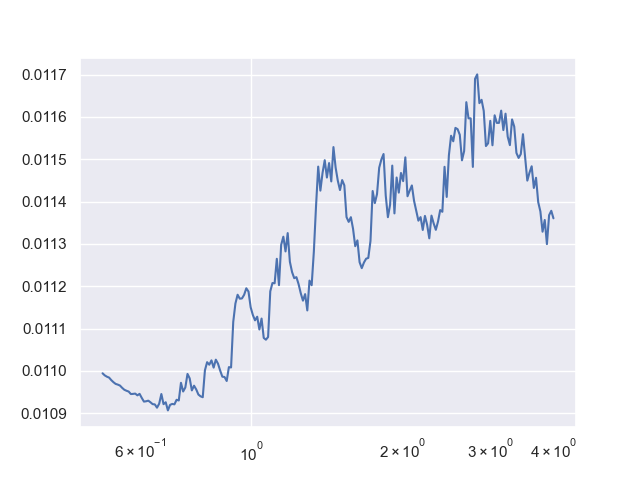

In [27]:

new_tm_fig = plt.figure()
new_tm_ax = new_tm_fig.add_subplot(1, 1, 1)



new_tm_res, = new_tm_ax.plot(10000/bin_grid,fb.bin_model(new_ace_tm.model(bin_grid))[1])
new_tm_ax.set_xscale('log')
#new_tm_fig.legend()
def new_tm_update(R=1.0, T = 2000.0, Z=1.0, CO=0.5, log_CH4=-5, log_TiO=-12):

    new_ace_tm['planet_radius'] = R
    new_ace_tm['T_irr'] = T
    new_ace_tm['metallicity'] = Z
    new_ace_tm['C_O_ratio'] = CO
    new_ace_tm['TiO'] = 10**log_TiO
    new_ace_tm['CH4'] = 10**log_CH4
    
    new_tm_res.set_ydata(fb.bin_model(new_ace_tm.model(bin_grid))[1])
    
    new_tm_fig.canvas.draw_idle()
    new_tm_ax.relim()
    new_tm_ax.autoscale_view()
    
interact(new_tm_update,R=(0.5,4.0), T=(400,4000,400), Z =(0.1,5.0), CO=(0.1,4.0), log_CH4=(-8,-4), log_TiO=(-12,-6));